In [1]:
import matplotlib.pyplot as plt
from skimage import io, img_as_float
!pip install tifffile 
!pip install imagecodecs
import tifffile as tiff
import imagecodecs
from scipy import ndimage as nd
from skimage.segmentation import random_walker
from skimage import exposure 
import numpy as np
import glob 
import cv2
from skimage import measure, color, io
from google.colab.patches import cv2_imshow
import pandas as pd

ERROR: Could not find a version that satisfies the requirement imagecodecs (from versions: none)
ERROR: No matching distribution found for imagecodecs


ModuleNotFoundError: No module named 'imagecodecs'

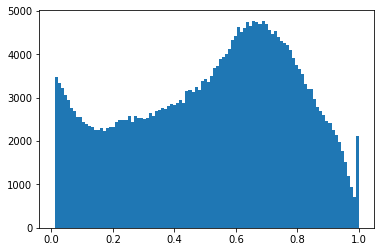

In [ ]:
img = img_as_float(io.imread("/content/micrograph251.tif"))

# Denosing the image.

from skimage.restoration import denoise_nl_means, estimate_sigma

sigma_est = np.mean(estimate_sigma(img, multichannel=True))
denoise_img = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=True, 
                              patch_size=5, patch_distance=3, multichannel=True)
                          

#Applying adaptive histogram equalization for better preprocessing.
eq_img = exposure.equalize_adapthist(denoise_img)
# plt.imshow(eq_img)
plt.imsave("/content/mark251.jpg",eq_img)
plt.hist(eq_img.flat, bins=100, range=(0.01, 1.))
# The range of the binary image spans over (0, 1).
# For markers, let us include all between each peak.
markers = np.zeros(img.shape, dtype=np.uint)
markers[(eq_img <0.15) & (eq_img > 0.01)] = 2
markers[(eq_img > 0.6) & (eq_img < 0.8)] = 1
plt.imsave("/content/mark251.2.jpg",markers)

<ipython-input-3-f219409be050>:1: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  labels = random_walker(eq_img, markers)


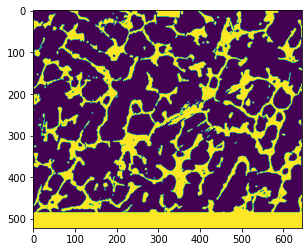

In [ ]:
labels = random_walker(eq_img, markers)
plt.imsave("/content/mark251.3.jpg",labels)
plt.imshow(labels)

In [ ]:
labels.shape

(522, 645)

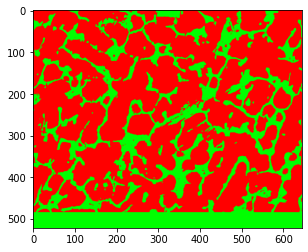

In [ ]:
segm1 = (labels == 1)
segm2 = (labels == 2)

#creating a blank image and filling it with everything from prior
#We are using markers to create labels and then applying those labels_img
all_segments = np.zeros((labels.shape[0],labels.shape[1],3))

all_segments[segm1] = (1,0,0)
all_segments[segm2] = (0,1,0)

plt.imsave("/content/mark251.4.jpg",all_segments)
plt.imshow(all_segments)

In [ ]:
#Now let's perform some morphological operations
test_img = cv2.imread("/content/mark251.4.jpg",0)
cropped_test_img = test_img[0:480,:]
kernal = np.ones((3,3),np.uint8)
eroded_test_img = cv2.erode(cropped_test_img,kernal, iterations = 1)
#dilated_test_img = cv2.dilate(cropped_test_img,kernal, iterations = 1)

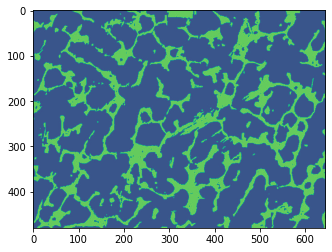

In [ ]:
plt.imshow(cropped_test_img)
plt.imsave("/content/mark251.5.jpg",eroded_test_img)

Grain Size analysis of Segmented Image

In [ ]:
#defining the size of each pixel
pixels_to_um = 0.5 # (1 px = 500 nm)
# Dividing the pixels into  clusters (or in our case grains) 
clusters = measure.regionprops(eroded_test_img,cropped_test_img)

#The output of the function is a list of object properties. 
#Output results into a csv file   
#Best way is to output all properties to a csv file
    
propList = ['Area',
            'equivalent_diameter', #Added... verify if it works
            'orientation', #Added, verify if it works. Angle btwn x-axis and major axis.
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']    
    

output_file = open('segmented_image_measurements8.csv', 'w')
output_file.write(',' + ",".join(propList) + '\n') #join strings in array by commas, leave first cell blank
#First cell blank to leave room for header (column names)

for cluster_props in clusters:
    #output cluster properties to the excel file
    output_file.write(str(cluster_props['Label']))
    for i,prop in enumerate(propList):
        if(prop == 'Area'): 
            to_print = cluster_props[prop]*pixels_to_um**2   #Convert pixel square to um square
        elif(prop == 'orientation'): 
            to_print = cluster_props[prop]*57.2958  #Convert to degrees from radians
        elif(prop.find('Intensity') < 0):          # Any prop without Intensity in its name
            to_print = cluster_props[prop]*pixels_to_um
        else: 
            to_print = cluster_props[prop]     #Reamining props, basically the ones with Intensity in its name
        output_file.write(',' + str(to_print))
    output_file.write('\n')
output_file.close()

Marking Each contours

Length of contours 224
(array([[[462, 431]]], dtype=int32), array([[[257, 430]],

       [[256, 431]],

       [[255, 431]],

       [[256, 431]],

       [[257, 431]],

       [[258, 431]],

       [[259, 431]],

       [[260, 431]],

       [[261, 431]],

       [[262, 431]],

       [[263, 431]],

       [[264, 431]],

       [[264, 430]],

       [[263, 430]],

       [[262, 430]],

       [[261, 430]],

       [[260, 430]],

       [[259, 430]],

       [[258, 430]]], dtype=int32), array([[[474, 429]],

       [[474, 430]],

       [[473, 431]],

       [[474, 431]],

       [[474, 430]]], dtype=int32), array([[[475, 427]]], dtype=int32), array([[[206, 426]],

       [[206, 427]],

       [[205, 428]],

       [[204, 429]],

       [[203, 430]],

       [[202, 430]],

       [[201, 431]],

       [[202, 431]],

       [[203, 431]],

       [[203, 430]],

       [[204, 429]],

       [[205, 429]],

       [[206, 428]],

       [[207, 428]],

       [[207, 427]],

       [[207, 426]

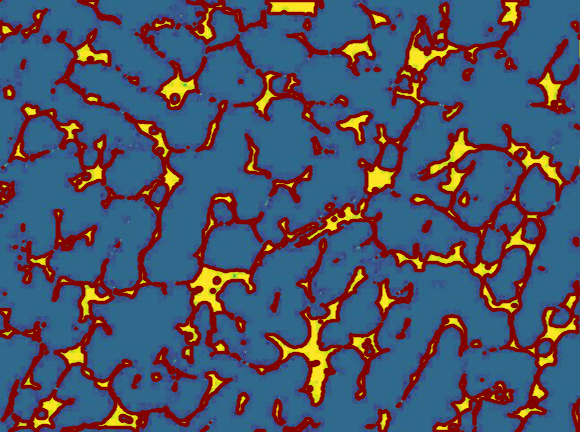

In [ ]:
import cv2
import numpy

#Read the image and convert it to grayscale
image = cv2.imread('/content/mark251.5.jpg')
image = cv2.resize(image, None, fx=0.9,fy=0.9)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Now convert the grayscale image to binary image
ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#Now detect the contours
contours, hierarchy = cv2.findContours(binary, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

#Visualize the data structure
print("Length of contours {}".format(len(contours)))
print(contours)

# draw contours on the original image
image_copy = image.copy()
image_copy = cv2.drawContours(image_copy, contours, -1, (0, 0, 130), thickness=2, lineType=cv2.LINE_AA)

#Visualizing the results

cv2_imshow(image_copy)
plt.imsave("/content/mark251.6.jpg",image_copy)

In [ ]:
df2 = pd.read_csv('/content/segmented_image_measurements8.csv')
df2

,Unnamed: 0,Area,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,Perimeter,MinIntensity,MeanIntensity,MaxIntensity
0,43,2.25,1.692569,45.000016,1.632993,1.632993,4.000000,43,82.111111,147
1,45,2.25,1.692569,45.000016,1.632993,1.632993,4.000000,45,87.777778,159
2,46,4.50,2.393654,-87.176071,223.277107,1.632993,8.000000,46,81.944444,149
3,47,2.25,1.692569,45.000016,1.632993,1.632993,4.000000,47,84.000000,131
4,49,2.25,1.692569,45.000016,1.632993,1.632993,4.000000,49,83.666667,144
...,...,...,...,...,...,...,...,...,...,...
100,147,1931.75,49.594158,-87.806135,357.007856,271.164803,2537.210245,147,150.277986,160
101,148,1061.50,36.763348,-85.054963,368.350461,271.112910,1308.939646,148,150.656618,162
102,149,579.00,27.151532,-80.056607,383.273897,272.346100,585.124892,149,150.209845,158
103,150,7406.50,97.109468,-81.997610,363.947117,275.115599,6344.765204,150,150.018666,158


Grain Size analysis of Raw file

In [ ]:
img = cv2.imread("/content/micrograph8.tif",0)
plt.imsave("/content/raw8.jpg",img)

In [ ]:
img = cv2.imread("/content/raw8.jpg",0)

#defining the size of each pixel
pixels_to_um = 0.5 # (1 px = 500 nm)
# Dividing the pixels into  clusters (or in our case grains) 
clusters = measure.regionprops(img)

#The output of the function is a list of object properties. 
#Output results into a csv file   
#Best way is to output all properties to a csv file
    
propList = ['Area',
            'equivalent_diameter', #Added... verify if it works
            'orientation', #Added, verify if it works. Angle btwn x-axis and major axis.
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter']    
    

output_file = open('raw_image_measurements8.csv', 'w')
output_file.write(',' + ",".join(propList) + '\n') #join strings in array by commas, leave first cell blank
#First cell blank to leave room for header (column names)

for cluster_props in clusters:
    #output cluster properties to the excel file
    output_file.write(str(cluster_props['Label']))
    for i,prop in enumerate(propList):
        if(prop == 'Area'): 
            to_print = cluster_props[prop]*pixels_to_um**2   #Convert pixel square to um square
        elif(prop == 'orientation'): 
            to_print = cluster_props[prop]*57.2958  #Convert to degrees from radians
        elif(prop.find('Intensity') < 0):          # Any prop without Intensity in its name
            to_print = cluster_props[prop]*pixels_to_um
        else: 
            to_print = cluster_props[prop]     #Reamining props, basically the ones with Intensity in its name
        output_file.write(',' + str(to_print))
    output_file.write('\n')
output_file.close()


Comparing the datasets ofsegmented and raw image

In [ ]:
df_raw = pd.read_csv('/content/raw_image_measurements8.csv')
df_raw

,Unnamed: 0,Area,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,Perimeter
0,1,1.25,1.261566,85.764190,238.531472,7.960969,0.0
1,2,2.00,1.595769,-60.388788,307.761364,180.661128,0.0
2,3,1.25,1.261566,88.146689,208.129749,16.260619,0.0
3,4,3.75,2.185097,-68.292062,417.506785,258.502792,0.0
4,5,3.50,2.111004,-65.774761,320.315049,209.429166,0.0
...,...,...,...,...,...,...,...
249,250,0.25,0.564190,45.000016,0.000000,0.000000,0.0
250,251,0.25,0.564190,45.000016,0.000000,0.000000,0.0
251,252,0.25,0.564190,45.000016,0.000000,0.000000,0.0
252,253,0.75,0.977205,-35.143321,153.948803,1.410103,0.0


In [ ]:
df_raw = pd.read_csv('/content/raw_image_measurements8.csv')
df_raw = df_raw.drop(['Unnamed: 0'], axis=1)
df2 = pd.read_csv('/content/segmented_image_measurements8.csv')
df_segmented = df2.drop(['MinIntensity','MeanIntensity','MaxIntensity','Unnamed: 0'], axis='columns')
df_segmented

,Area,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,Perimeter
0,2.25,1.692569,45.000016,1.632993,1.632993,4.000000
1,2.25,1.692569,45.000016,1.632993,1.632993,4.000000
2,2.25,1.692569,45.000016,1.632993,1.632993,4.000000
3,2.25,1.692569,45.000016,1.632993,1.632993,4.000000
4,2.25,1.692569,45.000016,1.632993,1.632993,4.000000
...,...,...,...,...,...,...
103,493.75,25.073134,-74.106563,383.854366,254.037590,658.619318
104,323.75,20.302988,-70.856619,389.667961,237.931187,388.654329
105,173.00,14.841511,-80.567005,342.856881,269.414830,189.730970
106,2965.75,61.450062,75.214313,412.057156,292.411426,2005.044246


In [ ]:
#comparing the two files using is in function
df_diffrence = df_raw[~df_raw.apply(tuple,1).isin(df_segmented.apply(tuple,1))]
df_diffrence

,Area,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,Perimeter
0,1.25,1.261566,85.764190,238.531472,7.960969,0.0
1,2.00,1.595769,-60.388788,307.761364,180.661128,0.0
2,1.25,1.261566,88.146689,208.129749,16.260619,0.0
3,3.75,2.185097,-68.292062,417.506785,258.502792,0.0
4,3.50,2.111004,-65.774761,320.315049,209.429166,0.0
...,...,...,...,...,...,...
245,1.50,1.381977,14.312187,274.428842,156.809614,0.0
246,0.75,0.977205,-63.211907,556.854344,128.590286,0.0
247,0.75,0.977205,-69.480322,461.227836,178.620625,0.0
248,1.25,1.261566,-87.143414,499.048630,77.166219,0.0


In [ ]:
#Finding the diffrence between the values of two file

df_value_diffrence = df_raw - df_segmented
df_value_diffrence.to_csv('df_value_diffrence.csv')